# Exploratory Analysis on Spark Streaming Dataset 

This is going to be really fun, since we are gonna consider raw data and explore whether it makes sense for us to use it for our purpose.

What's our purpose?
- We wanted to do a text classification, to determine whether the collected data make sense to get mannully tagged.
- We must ensure taht we have right kind of data with us before we spend time in tagging them for supervised learning

In [1]:
import os
import glob
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import imageio
plt.style.use('ggplot')
import json
import re
import nltk
nltk.download('punkt')
import spacy
import textacy
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /home/mageswarand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [3]:
RAW_PARQUET_FILES = "/tmp/ssp/raw_data/"

In [61]:
def get_raw_tweets(path):
    """
    Combines all parquet file as one in given path
    :param path: Folder path
    :return:
    """
    all_files = glob.glob(path + "/*.parquet")
    files = []
    for filename in all_files:
        if "part-00000-8f46a196-c1a7-4456-9b1d-f20098600014-c000" in filename:
            continue
        if filename.endswith(".parquet") and os.path.isfile(filename):
            df = pd.read_parquet(filename, engine="fastparquet")
            files.append(df)
    df = pd.concat(files, axis=0, ignore_index=True)
    return df

In [74]:
df = get_raw_tweets(RAW_PARQUET_FILES)

In [75]:
print("We have {} records in total".format(df.shape[0])) #28791

We have 30932 records in total


In [76]:
df.drop_duplicates(["full_text"], inplace=True)
df["expanded_url"] = df["expanded_url"].astype(str)
df["media_url_https"] = df["media_url_https"].astype(str)
df["text"] = df["full_text"]
df = df.drop(["full_text"], axis=1)
df

,created_at,text,source,expanded_url,media_url_https
0,Fri Mar 20 03:02:24 +0000 2020,"@Notintheface1 @Tweeted_Tongues No, I totally ...",Twitter Web App,[b'https://twitter.com/i/web/status/1240836057...,None
1,Thu Mar 19 13:09:20 +0000 2020,LEARNING AT HOME CHALLENGE #6. Think of your f...,Twitter Web App,[b'https://twitter.com/i/web/status/1240626410...,None
2,Thu Mar 19 13:09:23 +0000 2020,@SalemSchoolsk12 is offering enrichment activi...,Twitter for Android,[b'https://twitter.com/i/web/status/1240626422...,None
3,Thu Mar 19 13:30:34 +0000 2020,NBA boss Adam Silver defends players' access t...,Twitter for iPhone,[b'https://twitter.com/i/web/status/1240631754...,None
4,Thu Mar 19 13:30:42 +0000 2020,Big Play Slay is an Eagle and I’m hyped. Imagi...,Twitter for iPhone,[b'https://twitter.com/i/web/status/1240631788...,None
...,...,...,...,...,...
30927,Fri Mar 20 02:54:21 +0000 2020,This project has a very strong team. I am sure...,Twitter Web App,[b'https://twitter.com/i/web/status/1240834030...,None
30928,Sun Mar 22 09:26:59 +0000 2020,Very creative company and today one of the mos...,Twitter Web App,[b'https://twitter.com/i/web/status/1241657616...,None
30929,Fri Mar 20 02:34:15 +0000 2020,OLCF Corporation\nThe world's first decentrali...,Twitter Web App,[b'https://twitter.com/i/web/status/1240828974...,None
30930,Fri Mar 20 05:16:46 +0000 2020,"@caitoz Information is Beautiful, Data is Beau...",Twitter Web App,[b'https://twitter.com/i/web/status/1240869871...,None


In [53]:
def store_df_as_parquet(df, path):
    df["id"] = np.arange(0, len(df), dtype=int)
    df = df[["id", "text", "label"]]
    df.to_parquet(path, engine="fastparquet")

In [28]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
unlabeled_test_df = df[0:1000]  # 1K
unlabeled_val_df = df[1000:1500]  # 500
unlabeled_LF_df = df[1500:2500]  # 1K
unlabeled_train_df = df[2500:]  # 25+K

if not os.path.exists("ssp_tweet_dataset.parquet"):
    df.to_parquet("ssp_tweet_dataset.parquet", engine="fastparquet")
    store_df_as_parquet(df=unlabeled_test_df, path="ssp_test_dataset.parquet")
    store_df_as_parquet(df=unlabeled_val_df, path="ssp_val_dataset.parquet")
    store_df_as_parquet(df=unlabeled_LF_df, path="ssp_LF_dataset.parquet")
    unlabeled_train_df.to_parquet("ssp_train_dataset.parquet", engine="fastparquet")



In [77]:
df.columns

Index(['created_at', 'text', 'source', 'expanded_url', 'media_url_https'], dtype='object')

In [29]:
unlabeled_LF_df.reset_index(inplace=True, drop=True)
unlabeled_LF_df

,created_at,text,source,expanded_url,media_url_https
0,Sun Mar 22 07:20:19 +0000 2020,"Video: #AI, the end of #deeplearning ?\n#DeepL...",Zapier.com,[b'https://twitter.com/i/web/status/1241625742...,None
1,Fri Mar 20 08:04:53 +0000 2020,@VICE Life saving??? It is not very often tha...,TweetDeck,[b'https://twitter.com/i/web/status/1240912181...,None
2,Sat Mar 21 16:32:22 +0000 2020,"We feel very safe when Dr. Fauci speaks,share ...",Twitter for iPhone,[b'https://twitter.com/i/web/status/1241402279...,None
3,Fri Mar 20 08:31:08 +0000 2020,20. My current top 10\n\n1. 🇨🇭 Répondez-moi\n2...,Twitter for Android,[b'https://twitter.com/i/web/status/1240918788...,None
4,Fri Mar 20 20:29:01 +0000 2020,"""For several years, advocates have warned that...",Buffer,[b'https://twitter.com/i/web/status/1241099447...,None
...,...,...,...,...,...
995,Thu Mar 19 13:07:03 +0000 2020,@LFLegal @inspiredcat @Jeharrislaw @sbagen @DR...,Twitter for Android,[b'https://twitter.com/i/web/status/1240625834...,None
996,Sun Mar 22 07:06:43 +0000 2020,Football 101: Analytics Part 2\nDayne Young an...,Microsoft Power Platform,[b'https://twitter.com/i/web/status/1241622316...,None
997,Thu Mar 19 13:42:37 +0000 2020,I will do your #online #classes #homeworks &am...,Twitter for Android,[b'https://twitter.com/i/web/status/1240634784...,None
998,Sun Mar 22 07:22:34 +0000 2020,Police officers in #China use #AR helmets allo...,Twitter for iPhone,[b'https://twitter.com/i/web/status/1241626308...,None


In [30]:
text_data = unlabeled_LF_df["text"].values
text_data = [re.sub("http[s]?:\/\/\S+", "", row) for row in text_data]
# text_data

In [31]:
# img_mask=imageio.imread('../word_cloud_mask.png')

(-0.5, 399.5, 199.5, -0.5)

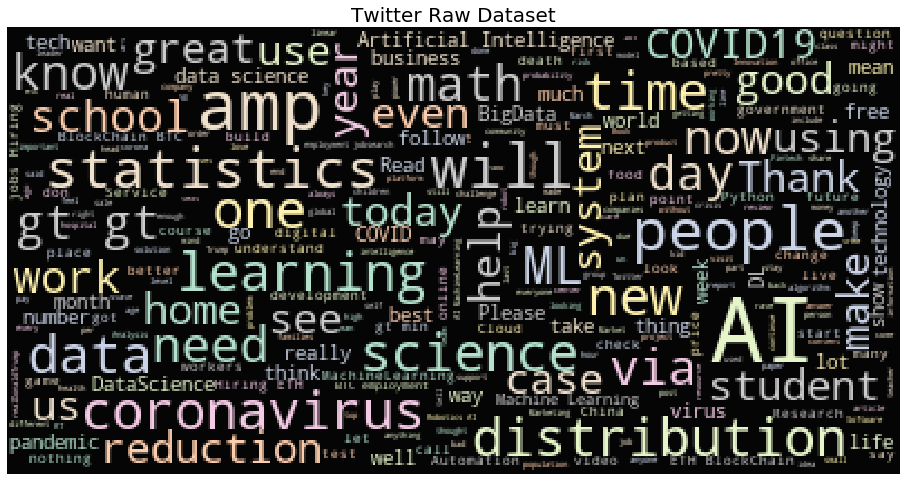

In [32]:
plt.figure(figsize=(16,13))

wc = WordCloud(background_color="black", 
               max_words=500, 
               stopwords=STOPWORDS, 
               max_font_size= 40)

wc.generate(" ".join(text_data))
plt.title("Twitter Raw Dataset", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

# Clustering Techniques

We have to go with unsupervised learning techniques, since we don't have labels with us.

In [35]:
text_df = unlabeled_LF_df.copy()
text_df = text_df.drop(["created_at", "source", "expanded_url", "media_url_https"], axis=1)

In [36]:
text_df

,text
0,"Video: #AI, the end of #deeplearning ?\n#DeepL..."
1,@VICE Life saving??? It is not very often tha...
2,"We feel very safe when Dr. Fauci speaks,share ..."
3,20. My current top 10\n\n1. 🇨🇭 Répondez-moi\n2...
4,"""For several years, advocates have warned that..."
...,...
995,@LFLegal @inspiredcat @Jeharrislaw @sbagen @DR...
996,Football 101: Analytics Part 2\nDayne Young an...
997,I will do your #online #classes #homeworks &am...
998,Police officers in #China use #AR helmets allo...


## Feature Engineering

**Data Preprocessing**

In [38]:
def preprocessing(df):
    # Remove punctuation
    df["text"] = df["text"].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
    # To smaller
    df["text"] = df["text"].apply(lambda x: x.lower())
    df["text"] = df["text"].apply(lambda x: x.replace("\n", " "))
    # Remove stop words ? for ML models
    # Lematization ? for ML models
    # Remove mentions
    # Tweets with more than 5 mentions/hashtag then consider it to be spam/useless, check with length
    return df

In [39]:
text_df = preprocessing(text_df)

### Labelling

In [40]:
KEYWORDS = "machine learning,#ML,#DL,deep learning,neural networks,tensorflow,pytorch,#AI,ai,artificial intelligence,big data science,data science,computer vision,image processing,text processing,data analytics,text analytics,kaggle".split(",")

def labelme(text, keyboards=KEYWORDS):
    res = 0
    for keyword in KEYWORDS:
        if keyword.lower() in text:
            res = 1
    return res

In [54]:
unlabeled_LF_df_labeled = unlabeled_LF_df.copy()
unlabeled_LF_df_labeled = preprocessing(unlabeled_LF_df_labeled)
unlabeled_LF_df_labeled["text"]

0      video ai the end of deeplearning  deeplearning...
1      vice life saving  it is not very often that el...
2      we feel very safe when dr fauci speaksshare we...
3      20 my current top 10  1  rpondezmoi 2  solovey...
4      for several years advocates have warned that w...
                             ...                        
995    lflegal inspiredcat jeharrislaw sbagen dredf n...
996    football 101 analytics part 2 dayne young and ...
997    i will do your online classes homeworks amp as...
998    police officers in china use ar helmets allowi...
999    farhanvirk to all those who dont understand th...
Name: text, Length: 1000, dtype: object

In [58]:
unlabeled_LF_df_labeled["label"] = unlabeled_LF_df_labeled["text"].apply(labelme)
store_df_as_parquet(df=unlabeled_LF_df_labeled, path="ssp_LF_dataset_labeled.parquet")

In [59]:
unlabeled_LF_df_labeled[["text", "label"]]

,text,label
0,video ai the end of deeplearning deeplearning...,1
1,vice life saving it is not very often that el...,0
2,we feel very safe when dr fauci speaksshare we...,0
3,20 my current top 10 1 rpondezmoi 2 solovey...,0
4,for several years advocates have warned that w...,0
...,...,...
995,lflegal inspiredcat jeharrislaw sbagen dredf n...,0
996,football 101 analytics part 2 dayne young and ...,0
997,i will do your online classes homeworks amp as...,0
998,police officers in china use ar helmets allowi...,1


In [60]:
unlabeled_LF_df_labeled["label"].value_counts()

0    515
1    485
Name: label, dtype: int64

**Count**

In [198]:
text_df["count"] = text_df["full_text"].apply(lambda x : len(x.strip().split(" ")))
text_df["label"] = text_df["full_text"].apply(labelme)
text_df

,full_text,count,label
0,data privacy is your concern we could help to ...,26,1
1,oliver bernard ltd business intelligence data...,26,1
2,wondering at the moment is there a correlation...,35,0
3,isnt one power an order like tell me what leve...,28,0
4,neighbors were having a dying tree cut down be...,57,0
...,...,...,...
995,at the heart of their algorithms is a scary bu...,43,1
996,ftblseb honestly rate yourself looks 710 cre...,39,0
997,via richardeudes why safeway grocery clerks w...,19,1
998,a japanese company is using ai and iot to reco...,21,1


In [199]:
text_df["label"].value_counts()

0    509
1    491
Name: label, dtype: int64

**n-gram**

In [85]:
# def ngramise(sequence):
#     '''
#     Iterate over bigrams and 1,2-skip-grams.
#     '''
#     for bigram in nltk.ngrams(nltk.word_tokenize(sequence), 2):
#         yield "_".join(bigram)
# text_df["2gram"] = text_df["full_text"].apply(lambda x : list(ngramise(x)))
# list(ngramise(text_df["full_text"].tolist()[0]))[:10]

#https://medium.com/reputation-com-datascience-blog/keywords-extraction-with-ngram-and-modified-skip-gram-based-on-spacy-14e5625fce23

In [130]:
X_text = text_df["full_text"]

**Vectorizers**   
Converts the text into numbers based on the words frequency, one way or other

In [131]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vectorizer = CountVectorizer(analyzer='word', stop_words=STOPWORDS, max_features=4096, ngram_range=(2, 2))

In [132]:
X_data = count_vectorizer.fit_transform(X_text)

/home/mageswarand/anaconda3/envs/vh/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [133]:
X_data.shape

(1000, 4096)

In [134]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X_data.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")


X_train size: 800
X_test size: 200 



### Dimensionality Reduction

Now we have extracted enough features for our training, but can we work with such high dimensional data? 
Dependending on the number of records the answer is yes/no. Considering the answer is no, as our systems can't hold huge arrays, lets reduce the features?

But wait? how do we know which one should keep and which should throw away?

Lets give that jobs to dimensionality reductions models/algorithms which can do it in more statistical way.


In [135]:
tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.116s...
[t-SNE] Computed neighbors for 800 samples in 3.934s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.435608
[t-SNE] KL divergence after 1000 iterations: 3.407533


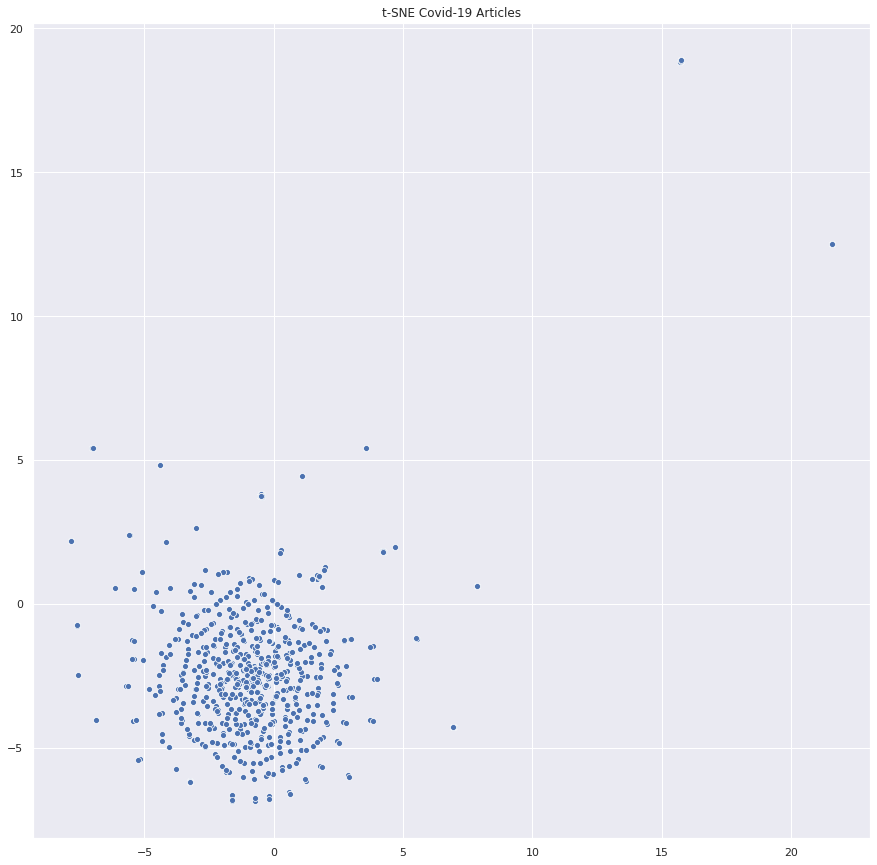

In [138]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE AI Tweets")
#plt.savefig("plots/t-sne_covid19.png")
plt.show()

In [7]:
# LDA

In [8]:
# KMeans

In [9]:
# LDA -> KMeans

In [ ]:
# Clustering Validation Metrics
# siloutte score
# perplexicity 